Finalne wagi: wx=0.4813, wRec=0.9734
Finalny błąd: 2.6872


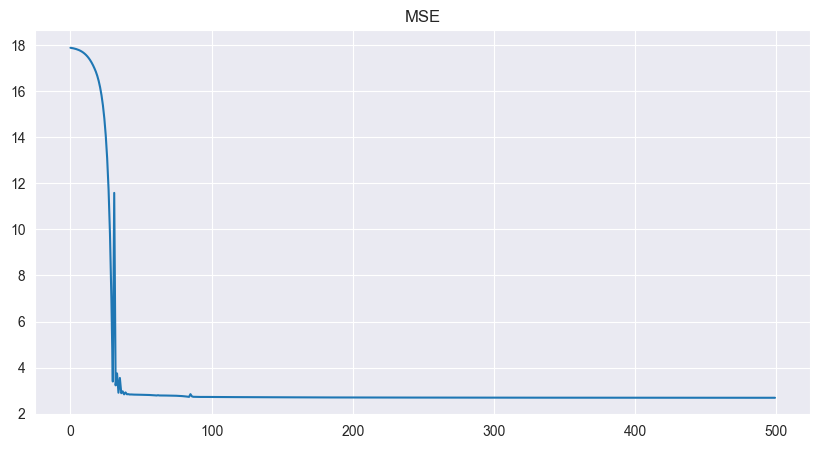

Test - Cel: 3, Wynik modelu: 3.3433


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

# Dane
nb_samples = 30
seq_len = 20
vals = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

X = np.random.choice(vals, size=(nb_samples, seq_len))
t = np.sum(np.isclose(X, 0.6), axis=1)

# Model RNN
def update_state(xk, sk, wx, wRec):
    return xk * wx + sk * wRec

def forward_states(X, wx, wRec):
    S = np.zeros((X.shape[0], X.shape[1] + 1))
    for k in range(0, X.shape[1]):
        S[:, k + 1] = update_state(X[:, k], S[:, k], wx, wRec)
    return S

def loss(y, t):
    return np.mean((t - y) ** 2)

def output_gradient(y, t):
    return 2. * (y - t)

# BPTT
def backward_gradient(X, S, grad_out, wRec):
    grad_over_time = np.zeros((X.shape[0], X.shape[1] + 1))
    grad_over_time[:, -1] = grad_out

    wx_grad = 0
    wRec_grad = 0

    for k in range(X.shape[1], 0, -1):
        wx_grad += np.sum(np.mean(grad_over_time[:, k] * X[:, k - 1], axis=0))
        wRec_grad += np.sum(np.mean(grad_over_time[:, k] * S[:, k - 1], axis=0))
        grad_over_time[:, k - 1] = grad_over_time[:, k] * wRec

    return (wx_grad, wRec_grad), grad_over_time

# RProp
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:, -1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads)

    for i, _ in enumerate(W):
        if W_sign[i] * W_prev_sign[i] > 0:
            W_delta[i] *= eta_p
        elif W_sign[i] * W_prev_sign[i] < 0:
            W_delta[i] *= eta_n
    return W_delta, W_sign

# Trening
eta_p, eta_n = 1.2, 0.5
W_delta = [0.001, 0.001]
W_prev_sign = [0, 0]
W = [np.random.uniform(-0.5, 0.5), np.random.uniform(0.5, 1.5)]

loss_history = []

for i in range(500):
    current_S = forward_states(X, W[0], W[1])
    loss_history.append(loss(current_S[:, -1], t))

    W_delta, W_sign = update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n)

    for idx, _ in enumerate(W):
        W[idx] -= W_sign[idx] * W_delta[idx]
    W_prev_sign = W_sign

print(f"Finalne wagi: wx={W[0]:.4f}, wRec={W[1]:.4f}")
print(f"Finalny błąd: {loss_history[-1]:.4f}")

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("MSE")
plt.show()

# Test
test_seq = [0.0, 0.2, 0.6, 0.8, 1.0, 0.6, 0.2, 0.4, 0.0, 0.6, 0.0, 0.2, 0.8, 1.0, 0.0, 0.2, 0.4, 0.8, 1.0, 0.0]
test_in = np.asmatrix([test_seq])
target = np.sum(np.isclose(test_in, 0.6))
out = forward_states(test_in, W[0], W[1])[:, -1][0]

print(f"Test - Cel: {target}, Wynik modelu: {out:.4f}")